In [1]:
## import
using Gmsh
using Plots
using Printf
using LinearSolve
using LinearAlgebra

In [2]:
## function for reordering of coordinates
function reorderCoords(tags, coords)
    # get the number of nodes
    NPnts = length(tags)

    # create an empty list to save coordinates
    nodeCrds = zeros(3*NPnts)

    # loop over nodes
    for n in 1:1:NPnts
        # extract coordinates
        coord1 = coords[3*(n-1) + 1]
        coord2 = coords[3*(n-1) + 2]
        coord3 = coords[3*(n-1) + 3]

        # place them in the right order
        nodeCrds[3*(nodeTags[n]-1) + 1] = coord1
        nodeCrds[3*(nodeTags[n]-1) + 2] = coord2
        nodeCrds[3*(nodeTags[n]-1) + 3] = coord3
    end

    # return the reordered list of coordinates
    return nodeCrds
end

reorderCoords (generic function with 1 method)

In [3]:
## function to calculate area of elements
function calcElementsAreas(elemTags, elemToNode, nodeCrds)
    # get the number of elements
    NElms = length(elemTags)

    # create an empty list to save areas
    areas = zeros(NElms)

    # loop over elements
    for e in 1:1:NElms
        # element nodes
        node1 = elemToNode[1][3*(e-1) + 1]
        node2 = elemToNode[1][3*(e-1) + 2]
        node3 = elemToNode[1][3*(e-1) + 3]

        # nodes coordinates
        x1 = nodeCrds[3*(node1-1) + 1]
        x2 = nodeCrds[3*(node2-1) + 1]
        x3 = nodeCrds[3*(node3-1) + 1]

        y1 = nodeCrds[3*(node1-1) + 2]
        y2 = nodeCrds[3*(node2-1) + 2]
        y3 = nodeCrds[3*(node3-1) + 2]

        z1 = nodeCrds[3*(node1-1) + 3]
        z2 = nodeCrds[3*(node2-1) + 3]
        z3 = nodeCrds[3*(node3-1) + 3]

        # distances
        a = sqrt((x1-x2)^2 + (y1-y2)^2 + (z1-z2)^2)
        b = sqrt((x2-x3)^2 + (y2-y3)^2 + (z2-z3)^2)
        c = sqrt((x3-x1)^2 + (y3-y1)^2 + (z3-z1)^2)

        # semiperimeter
        s = 0.5*(a + b + c)

        # area
        S = sqrt(s*(s - a)*(s - b)*(s - c))
        areas[e] = S
    end

    # return the list of areas
    return areas
end

calcElementsAreas (generic function with 1 method)

In [4]:
## function to set forcing in selected nodes
function setForcing(fVals, fNodes, nodeTags)
    # get the number of nodes
    NPnts = length(nodeTags)

    # create an empty forcing vector
    f = zeros(NPnts)

    # loop over the nodes
    nSet = 0 # number of already set nodes
    for n in 1:1:NPnts
        if n in fNodes
            f[fNodes[nSet+1]] = fVals[nSet+1]
            nSet += 1
        end
    end

    # return  the forcing vector
    return f
end

setForcing (generic function with 1 method)

In [5]:
## function to create the stiffness matrix (K)
function createKMatrix(elemTags, areas, elemToNode, nodeCrds)
    # get the number of elements and nodes
    NElms = length(elemTags)
    NPnts = floor(Int, length(nodeCrds)/3)

    # create an empty K matrix
    K = zeros((NPnts,NPnts))

    # loop over elements
    for e in 1:1:NElms
        # element nodes
        node1 = elemToNode[1][3*(e-1) + 1]
        node2 = elemToNode[1][3*(e-1) + 2]
        node3 = elemToNode[1][3*(e-1) + 3]

        # nodes coordinates
        x1 = nodeCrds[3*(node1-1) + 1]
        x2 = nodeCrds[3*(node2-1) + 1]
        x3 = nodeCrds[3*(node3-1) + 1]

        y1 = nodeCrds[3*(node1-1) + 2]
        y2 = nodeCrds[3*(node2-1) + 2]
        y3 = nodeCrds[3*(node3-1) + 2]

        z1 = nodeCrds[3*(node1-1) + 3]
        z2 = nodeCrds[3*(node2-1) + 3]
        z3 = nodeCrds[3*(node3-1) + 3]

        # weighting functions
        # vi = ai*x + bi*y + ci
        # first node
        dirac = [1.0, 0.0, 0.0]
        A = [x1 y1 1; x2 y2 1; x3 y3 1]

        prob = LinearProblem(A, dirac)
        sol = solve(prob)
        a1, b1, c1 = sol.u

        # second node
        dirac = [0.0, 1.0, 0.0]
        A = [x1 y1 1; x2 y2 1; x3 y3 1]

        prob = LinearProblem(A, dirac)
        sol = solve(prob)
        a2, b2, c2 = sol.u

        # third node
        dirac = [0.0, 0.0, 1.0]
        A = [x1 y1 1; x2 y2 1; x3 y3 1]

        prob = LinearProblem(A, dirac)
        sol = solve(prob)
        a3, b3, c3 = sol.u
        
        # create local stiffness matrix (Ke)
        Ke = zeros((3,3))
        Ke[1,1] = a1*a1 + b1*b1
        Ke[1,2] = a1*a2 + b1*b2
        Ke[1,3] = a1*a3 + b1*b3

        Ke[2,1] = a2*a1 + b2*b1
        Ke[2,2] = a2*a2 + b2*b2
        Ke[2,3] = a2*a3 + b2*b3

        Ke[3,1] = a3*a1 + b3*b1
        Ke[3,2] = a3*a2 + b3*b2
        Ke[3,3] = a3*a3 + b3*b3

        Ke *= areas[e]

        # local to global assembly of K
        K[node1,node1] += Ke[1,1]
        K[node1,node2] += Ke[1,2]
        K[node1,node3] += Ke[1,3]

        K[node2,node1] += Ke[2,1]
        K[node2,node2] += Ke[2,2]
        K[node2,node3] += Ke[2,3]

        K[node3,node1] += Ke[3,1]
        K[node3,node2] += Ke[3,2]
        K[node3,node3] += Ke[3,3]
    end

    # return the K matrix
    return K
end

createKMatrix (generic function with 1 method)

In [6]:
## function to create the forcing vector (f)
function createFVector(fIn, elemTags, areas, elemToNode)
    # get the number of elements and nodes
    NElms = length(elemTags)
    NPnts = floor(Int, length(nodeCrds)/3)

    # create an empty f vector
    f = zeros(NPnts)

    # loop over the elements
    for e in 1:1:NElms
        # element nodes
        node1 = elemToNode[1][3*(e-1) + 1]
        node2 = elemToNode[1][3*(e-1) + 2]
        node3 = elemToNode[1][3*(e-1) + 3]

        # create a local forcing vector (fe)
        fe = zeros(3)
        fe[1] = fIn[node1]
        fe[2] = fIn[node2]
        fe[3] = fIn[node3]

        fe *= areas[e]/3

        # local to global assembly of f
        f[node1] += fe[1]
        f[node2] += fe[2]
        f[node3] += fe[3]
    end

    # return the f vector
    return f
end

createFVector (generic function with 1 method)

In [7]:
## function to change the forcing vector to enforce Dirichlet boundary conditions
function enforceDirichletBC(K, f, dVals, dNodes)
    # get the number of affected nodes
    NPnts = length(dNodes)

    # get the size of the stiffness matrix
    NRows, NCols = size(K)

    # loop over the affected nodes and overwrite the forcing vector
    for d in 1:1:NPnts
        # get the node tag
        nodeTag = dNodes[d]

        # loop over all nodes
        for n in 1:1:length(f)
            # subtract from f
            f[n] -= K[n,nodeTag]*dVals[d]
        end
    end

    # create a smaller forcing vector without the affected nodes
    fs = zeros(length(f)-NPnts)
    nSkip = 0 # number of already skipped nods
    for n in 1:1:length(f)
        # if n is affected skip
        if (n in dNodes)
            nSkip += 1
            continue
        end

        # else copy from f to fs
        fs[n-nSkip] = f[n]
    end

    # create a smaller stiffness matrix without the affected nodes
    Ks = zeros((NRows-NPnts, NRows-NPnts))
    rSkip = 0 # number of already skipped rows
    for r in 1:1:NRows
        cSkip = 0 # number of skipped cols in a row

        # if r is affected skip
        if (r in dNodes)
            rSkip += 1
            continue
        end

        # loop over columns
        for c in 1:1:NCols
            # if c is affected skip
            if (c in dNodes)
                cSkip += 1
                continue
            end

            # else copy from K to Ks
            Ks[r-rSkip,c-cSkip] = K[r,c]
        end
    end

    # return the overwritten forcing vector
    return Ks,fs
end

enforceDirichletBC (generic function with 1 method)

In [8]:
## function to extend the resulting vector by nodes affected by the Dirichlet boundary condition
function extendCByDirBC(c, dVals, dNodes)
    # get the resulting number of nodes
    NPnts = length(c) + length(dNodes)

    # create an extended c
    cb = zeros(NPnts)
    nAdd = 0 # number of already added nodes
    for n in 1:1:NPnts
        if n in dNodes
            cb[dNodes[nAdd+1]] = dVals[nAdd+1]
            nAdd += 1
        else
            cb[n] = c[n-nAdd]
        end
    end

    # return the extended solution vector c
    return cb
end

extendCByDirBC (generic function with 1 method)

In [9]:
## function to plot the solution
function plotC(c, nodeTags, nodeCrds)
    # get the number of nodes
    NPnts = length(nodeTags)

    # prepare empty list for plotting
    xx = zeros(NPnts)
    yy = zeros(NPnts)
    zz = zeros(NPnts)

    # loop over the nodes
    for n in 1:1:NPnts
        # get the coordinates
        xx[n] = nodeCrds[3*(n-1) + 1]
        yy[n] = nodeCrds[3*(n-1) + 2]
        zz[n] = nodeCrds[3*(n-1) + 3]
    end
    
    # plot
    plot(xx, yy, c, st=:surface)
    scatter!(xx, yy, c, color = "black", label = "c")
end

plotC (generic function with 1 method)

In [10]:
## initialize
gmsh.initialize()

## load mesh file
gmsh.merge("./staticMesh.msh")

Info    : Reading './staticMesh.msh'...
Info    : 9 entities
Info    : 142 nodes
Info    : 246 elements
Info    : Done reading './staticMesh.msh'


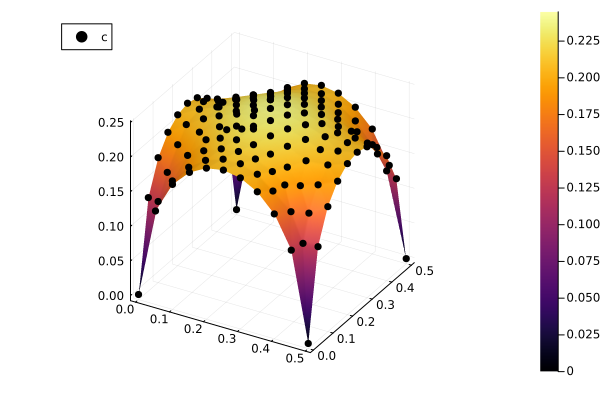

In [11]:
## access elements and nodes
elemTypes, elemTags, elemToNode = gmsh.model.mesh.getElements(2, 1)
elemTags = elemTags[1]
NElms = length(elemTags)

nodeTags, coords, params = gmsh.model.mesh.getNodes(2, 1, true);
NPnts = length(nodeTags)

staticNodeTags, staticCoords = gmsh.model.mesh.getNodesForPhysicalGroup(0, 2);
dNodes = staticNodeTags
dVals = zeros(length(dNodes))

setForceNodeTags, setForceNodeCoords = gmsh.model.mesh.getNodesForPhysicalGroup(2, 1);
fNodes = setForceNodeTags

## reorder node coordinates
nodeCrds = reorderCoords(nodeTags, coords)

## calculate area of elements
areas = calcElementsAreas(elemTags, elemToNode, nodeCrds)

## create the K matrix
K = createKMatrix(elemTags, areas, elemToNode, nodeCrds)

## create the f vector
fVals = zeros(NPnts)
for n in 1:1:NPnts
    # node coordinates
    x = nodeCrds[3*(n-1) + 1]
    y = nodeCrds[3*(n-1) + 2]

    # calculate force
    fVals[n] = (x*(0.5-x)*y*(0.5-y))*1e3
end

fIn = setForcing(fVals, fNodes, nodeTags)
f = createFVector(fIn, elemTags, areas, elemToNode)

## enforce Dirichlet boundary conditions
K, f = enforceDirichletBC(K, f, dVals, dNodes)

## solve the linear static system
prob = LinearProblem(K, f)
sol = solve(prob)
c = sol.u

## extend the resulting c vector by the nodes affected by Dirichlet boudnary conditions
c = extendCByDirBC(c, dVals, dNodes)

## plot the final solution
plotC(c, nodeTags, nodeCrds)